# Example 2

Example 2 illustrates some of the flexibility of tcrdist2. See Example 1 for more detailed explanations of the step-wise procedure and TCRrep class.

In [1]:
import pandas as pd
import numpy as np 
import parasail

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tcrdist as td
from tcrdist import mappers
from tcrdist.repertoire import TCRrep
from tcrdist.vis_tools import bostock_cat_colors, cluster_viz

# Preliminary Steps

## Load, Format, and Subset the Data

In [2]:
pd_df = pd.read_csv("vdjDB_PMID28636592.tsv", sep = "\t")       # 1
t_df = td.mappers.vdjdb_to_tcrdist2(pd_df = pd_df)              # 2
t_df.organism.value_counts                                      # 3
index_mus = t_df.organism == "MusMusculus"                      # 4
t_df_mus = t_df.loc[index_mus,:].copy()                         # 5

1. Read the .tsv data file into a pandas DataFrame.

2. Call tcrdist.mappers.vdjdb_to_tcrdist2() to select and rename the appropriate columns. 
 
3. The data has both human and mouse TCRs, which can't be combined in a single repertoire.

4. Index the sequences that come from MusMusculus (mouse).

5. Create a copy of the subset DataFrame t_df, including only mouse TCRs: t_df_mus.

## tr1 - Initialize the Repertoire

In [3]:
tr1 = TCRrep(cell_df = t_df_mus, organism = "mouse")             # 6
tr1.infer_cdrs_from_v_gene(chain = 'alpha')                      # 7
tr1.infer_cdrs_from_v_gene(chain = 'beta')                       # 8
tr1.index_cols =['epitope',                                      # 9 
                'subject',
                'cdr3_a_aa',
                'cdr1_a_aa',
                'cdr2_a_aa',
                'pmhc_a_aa',
                'cdr3_b_aa',
                'cdr1_b_aa',
                'cdr2_b_aa',
                'pmhc_b_aa']
tr1.deduplicate()                                                # 10

tcrdist.repertoire.TCRrep for <Your TCR Repertoire Project>
 with index_cols: ['epitope', 'subject', 'cdr3_a_aa', 'cdr1_a_aa', 'cdr2_a_aa', 'pmhc_a_aa', 'cdr3_b_aa', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa']
 with model organism: mouse

Detailed explanations of the steps shown above can be found in Example 1 
    
6. Create an instance of the tcrdist.repertoire.TCRrep class initialized with the t_df_mus DataFrame.

7. Use tcrdist.repertoire.TCRrep.infer_cdrs_from_v_gene() to populate CDR1, CDR2 and pMHC loop fields.

8. Repeat step 7, with chain set to ‘beta’.

9. Specify index columns. Any sequence identical across all the index columns will be grouped at the following step. The count field keeps track of the number of identical clones (which may occur during clonal expansion)

10. Call tcrdist.repertoire.TCRrep.deduplicate() to remove duplicates and create the tcrdist.repertoire.TCRrep.clone_df DataFrame.

# How to calcuate a tcrdist 

Once region based pairwise comparison have been generated with `compute_pairwise_all( )`, there are two ways to compute a tcrdist with user defined weights.

**Method 1.** One can simply access individual pairwise matrices after `compute_pairwise_all( )`. Because the dimensions are row order in clone_df. Individual pairewise matrices from different regions can be combined, and weighted:

```python


# tcrdist1 = (cdr3_alpha) 
  tcrdist1 = tr1.cdr3_a_aa_pw 


# tcrdist2 =  3*(cdr3_alpha)     + 3*(cdr4_beta)        
  tcrdist2   =  3 * tr1.cdr3_a_aa_pw  + 3 * trd.cdr3_b_aa_pw 


# tcrdist3   3*(cdr3_alpha)        + 3*(cdr4_beta)        + 1*(cdr1_alpha)       + 1*(cdr1_beta)
  tcrdist3 = 3 * tr1.cdr3_a_aa_pw  + 3 * trd.cdr3_b_aa_pw + 1 * trd.cdr1_a_aa_pw + 1 * trd.cdr1_b_aa_pw 

```

**Method2** Alternatively use the builtin function `.compute_paired_tcrdist( )` with a dictionary of weights:

```python
# tcrdist1
weights1 = 

{'cdr3_a_aa_pw': 3,'cdr3_b_aa_pw': 0, 
 'cdr2_a_aa_pw': 0,'cdr2_b_aa_pw': 0,
 'cdr1_a_aa_pw': 0,'cdr1_b_aa_pw': 0, 
 'pmhc_a_aa_pw': 0,'pmhc_b_aa_pw': 0}

# or
# tcrdist2 
weights2 = 
{'cdr3_a_aa_pw': 3,'cdr3_b_aa_pw': 3, 
 'cdr2_a_aa_pw': 0,'cdr2_b_aa_pw': 0,
 'cdr1_a_aa_pw': 0,'cdr1_b_aa_pw': 0, 
 'pmhc_a_aa_pw': 0,'pmhc_b_aa_pw': 0}

# or
# tcrdist3
weights3 = 
{'cdr3_a_aa_pw': 3,'cdr3_b_aa_pw': 0, 
 'cdr2_a_aa_pw': 0,'cdr2_b_aa_pw': 0,
 'cdr1_a_aa_pw': 1,'cdr1_b_aa_pw': 1, 
 'pmhc_a_aa_pw': 0,'pmhc_b_aa_pw': 0}

tcrdist1 = tr.compute_paired_tcrdist(replacement_weights = weights1, store_result = True)
tcrdist2 = tr.compute_paired_tcrdist(replacement_weights = weights2, store_result = True)
tcrdist3 = tr.compute_paired_tcrdist(replacement_weights = weights3, store_result = True)

```

When using the builtin method (store_result = True) the tcrdist matrices and weights can be accessed later:

```python

tr.stored_tcrdist[-3]
tr.stored_tcrdist[-2]
tr.stored_tcrdist[-1]

```

# Compute Hamming Distance Based Scores

In [4]:
tr1.compute_pairwise_all(chain = "alpha",                         # 11
                        metric = "hamming",
                        processes = 6,
                        matrix = parasail.blosum62)

tr1.compute_pairwise_all(chain = "beta",                          # 12
                        metric = "hamming",
                        processes = 6,
                        matrix = parasail.blosum62)

11. with metric argument is set to either ‘hamming’, ‘nw’ or ‘custom’, tcrdist2 uses python’s multiprocessing package to parallelize pairwise distance computation.

12. Repeat the previous step setting chain argument to ‘beta’.

## tcrdist : CDR3_alpha (Hamming Distance)

/Users/kmayerbl/PycharmProjects/pretend_to_be_a_user/tUser2/venv/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


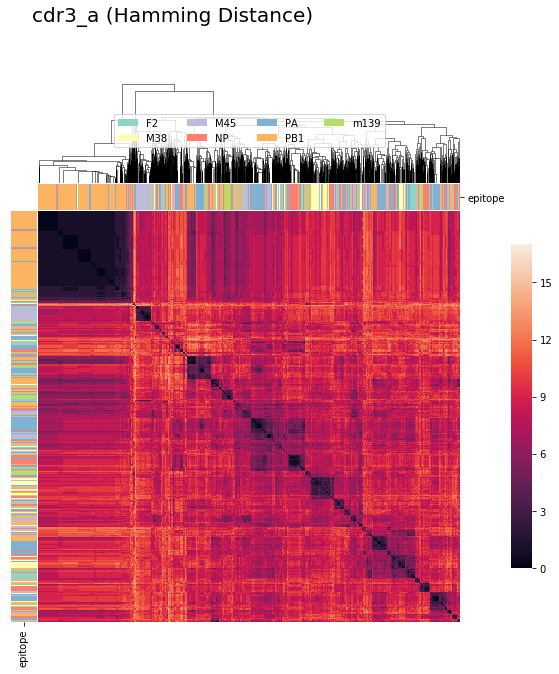

In [5]:
tcrdist1a  = pd.DataFrame(tr1.cdr3_a_aa_pw)
cluster_viz(tcrdist1a, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "cdr3_a (Hamming Distance)")

## tcrdist : CDR3_beta (Hamming Distance)

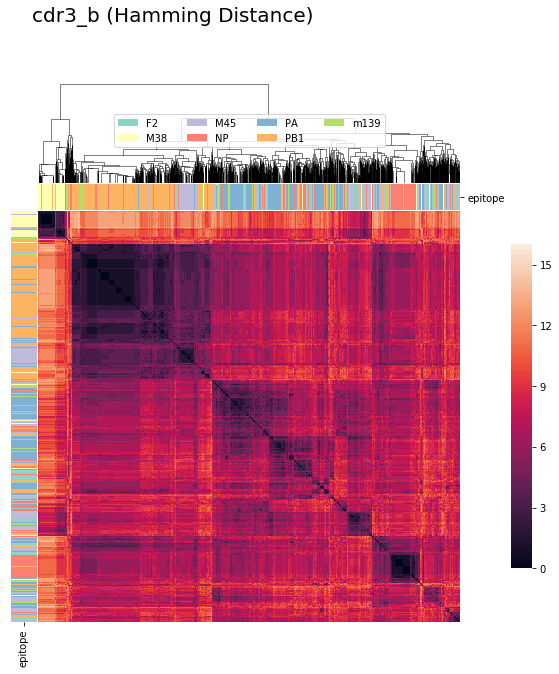

In [6]:
tcrdist1b  = pd.DataFrame(tr1.cdr3_b_aa_pw )
cluster_viz(tcrdist1b, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "cdr3_b (Hamming Distance)")

## tcrdist : CDR3_alpha + CDR3_beta (Hamming Distance)

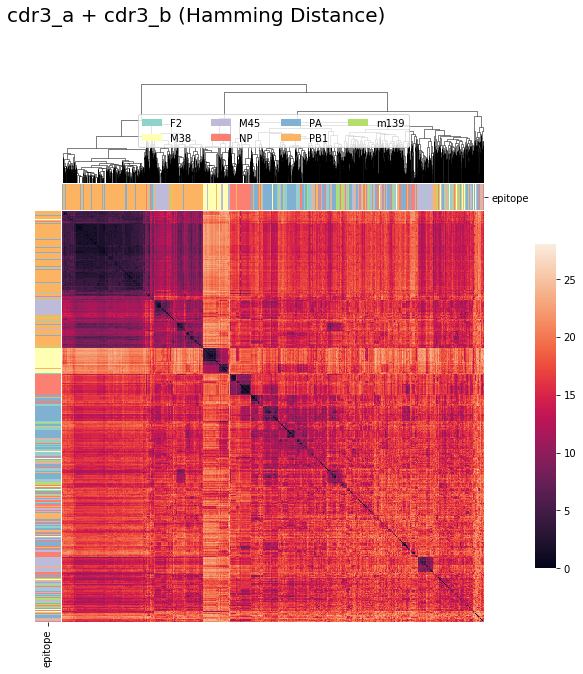

In [7]:
tcrdist2  = pd.DataFrame(tr1.cdr3_a_aa_pw + tr1.cdr3_b_aa_pw )
cluster_viz(tcrdist2, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "cdr3_a + cdr3_b (Hamming Distance)")

## tcrdist :  CDR3_alpha + CDR3_beta + Other CDR Regions (Hamming Distance)

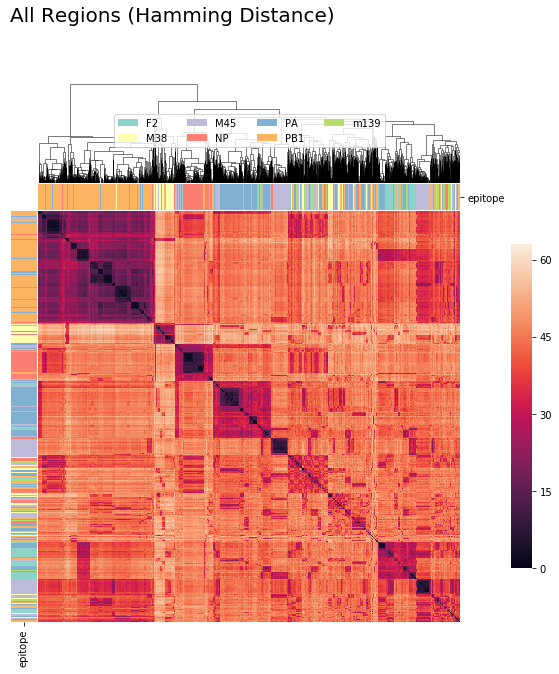

In [8]:
tcrdist3 = pd.DataFrame(tr1.compute_paired_tcrdist(store_result= False)['paired_tcrdist'])
cluster_viz(tcrdist3, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "All Regions (Hamming Distance)")

# Weights

## CDR3_alpha + CDR3_beta + Other CDR Regions (Weighted Hamming Distance)

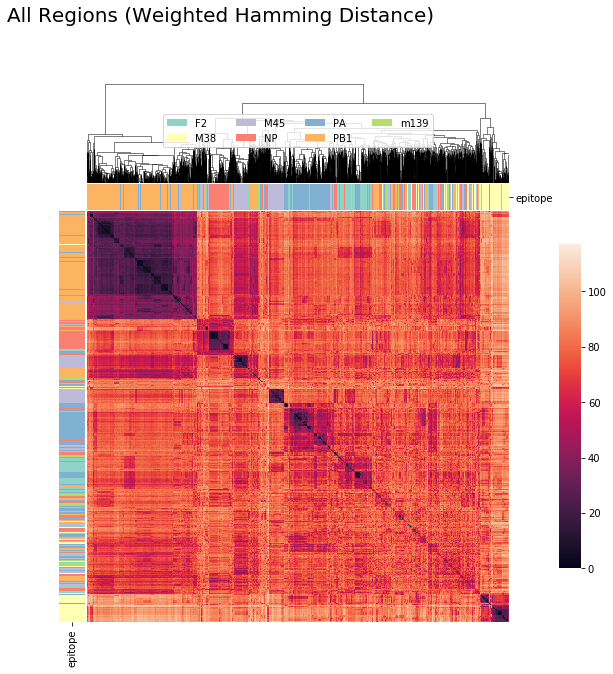

In [9]:
tcrdist3w = tr1.compute_paired_tcrdist(store_result= False,
                                     replacement_weights = {'cdr3_a_aa_pw': 3,
                                                            'cdr3_b_aa_pw': 3})
tcrdist = pd.DataFrame(tcrdist3w['paired_tcrdist'])
cluster_viz(tcrdist, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "All Regions (Weighted Hamming Distance)")

# Substitution Matrix Based Distance Scores

It is at the `.compute_pairwise_all( )` step that the choice of distance metric is specified. When the method is specified as 'nw' a reciprocal alignment score is calculated which is function of the subsitution matrix used to score the optimal alignment (see more explanation in example 1).

In [10]:
tr1.compute_pairwise_all(chain = "alpha",                         # 11
                        metric = "nw",
                        processes = 6,
                        matrix = parasail.blosum62)

tr1.compute_pairwise_all(chain = "beta",                          # 12
                        metric = "nw",
                        processes = 6,
                        matrix = parasail.blosum62)

### CDR3_alpha + CDR3_beta + Other CDR Regions (Weighted NW Sub Matrix Based Distance)

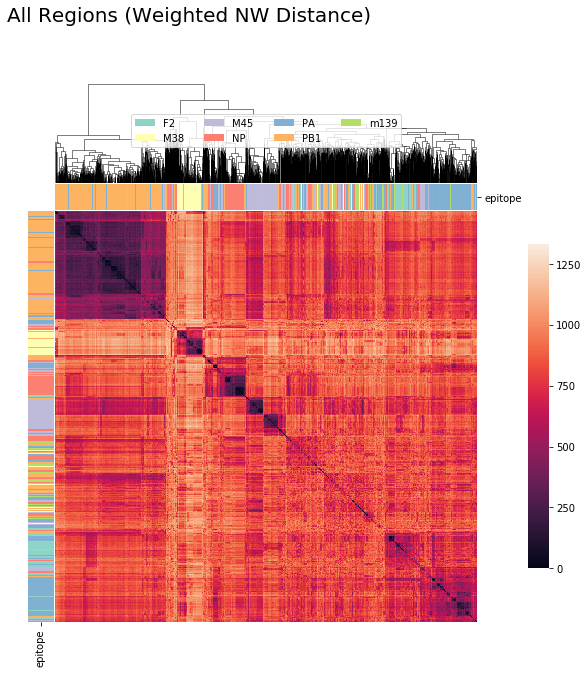

In [11]:
tcrdist = tr1.compute_paired_tcrdist(store_result= False,
                                     replacement_weights = {'cdr3_a_aa_pw': 3,
                                                            'cdr3_b_aa_pw': 3})
tcrdist = pd.DataFrame(tcrdist['paired_tcrdist'])
cluster_viz(tcrdist, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "All Regions (Weighted NW Distance)")


# tcrdist2 Can Parallelize Custom Metrics

## suppose we imagine some metric

In [12]:
def hydrophobic_custom_metric(s1, s2):
    
    s1 = s1.upper()
    s2 = s2.upper()
    
    # Types of Amino Acids
    # positive_charged = ["R", "H", "K"]
    
    # negative_charged = ["D","E"]
    
    # polar_side_chain = ["S", "T", "N", "Q"]
    
    # special_cases    = ["C", "U", "G", "P"]
    
    hydrophobes      = ["A", "I", "L", "M", "W", "Y", "V"]
    
    # count the number of hydrophobic amino acids in s1
    h1 = np.sum([x in hydrophobes for x in list(s1)])
    
    # count the number of hydrophobic amino acids in s2
    h2 = np.sum([x in hydrophobes for x in list(s2)])
    
    # calculate the absolute difference in hydrophobic amino acids
    hydrophobic_absolute_dif = abs(h1-h2)
    
    return int(hydrophobic_absolute_dif) 

## It can be passed to `compute_pairwise_all( )`

In [13]:
tr1.compute_pairwise_all(chain = "alpha",                          # 12
                         metric = "custom", # <----------- set metric to custom 
                         processes = 6,
                         user_function = hydrophobic_custom_metric) # <----------- supply your custom function

tr1.compute_pairwise_all(chain = "beta",                          # 12
                         metric = "custom", # <----------- set metric to custom 
                         processes = 6,
                         user_function = hydrophobic_custom_metric) # <----------- supply your custom function

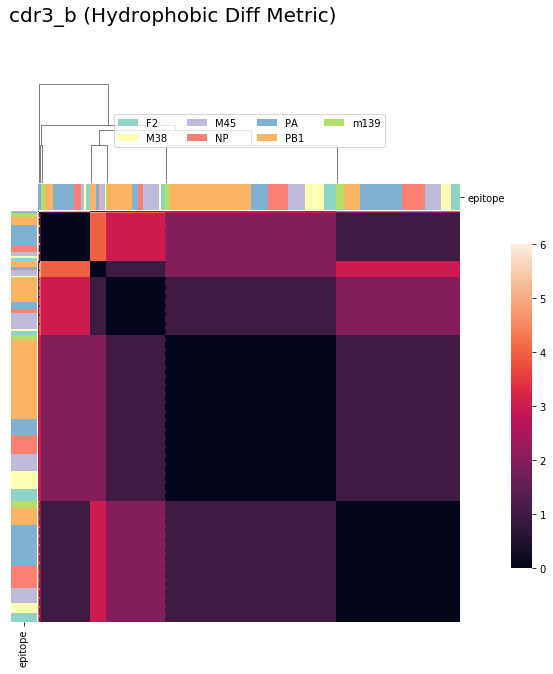

In [14]:
tcrdist  = pd.DataFrame(tr1.cdr3_b_aa_pw)
cluster_viz(tcrdist, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "cdr3_b (Hydrophobic Diff Metric)")

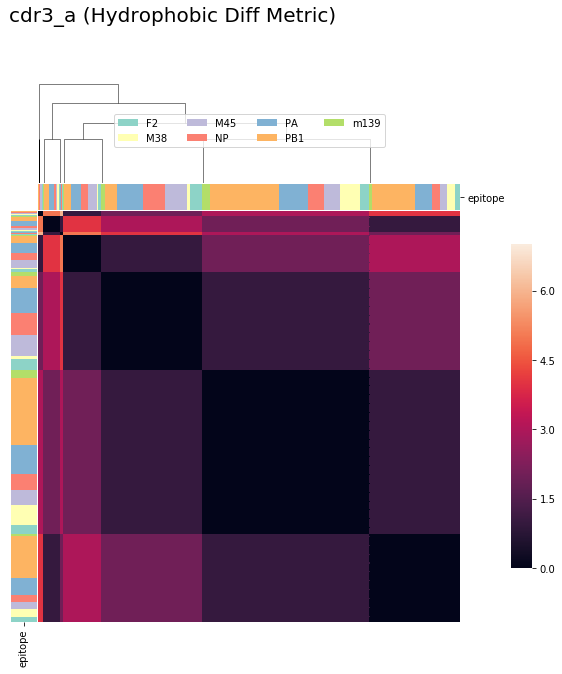

In [15]:
tcrdist  = pd.DataFrame(tr1.cdr3_a_aa_pw)
cluster_viz(tcrdist, 
            tr1.clone_df, 
            tr1.clone_df.epitope.unique(), 
            bostock_cat_colors(['set3']),
            "cdr3_a (Hydrophobic Diff Metric)")

# Code For Making Plots 

This code is now avialable in td.vis_tools

``` python

def bostock_cat_colors(color_sets = ["set3"]):

    """
    Get almost as many categorical colors as you please.

    Get more than one of the color brewer sets with ['set1' , 'set2']


    Parameters
    ----------
    
    sets : list
        list of color sets to return valid options are
        (set1, set2, set3, pastel1, pastel2, paired, dark, accent, category10)

    Returns
    -------
    
    categorical_colors : list
        list of strings (e.g. ["#e41a1c",...])

    Examples
    --------
    
    >>> bostock_cat_colors(['set3'])[:5]
    ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

    >>> bostock_cat_colors(['category10'])[:5]
    ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    Notes
    -----
    
    list of hex colors can be found here:
    https://observablehq.com/@d3/color-schemes


    """
    bostock = \
    {"set1"     : ["#e41a1c","#377eb8","#4daf4a","#984ea3",
                   "#ff7f00","#ffff33","#a65628","#f781bf",
                   "#999999"],
     "set2"     : ["#66c2a5","#fc8d62","#8da0cb","#e78ac3",
                   "#a6d854","#ffd92f","#e5c494","#b3b3b3"],

     "set3"     : ["#8dd3c7","#ffffb3","#bebada","#fb8072",
                   "#80b1d3","#fdb462","#b3de69","#fccde5",
                   "#d9d9d9","#bc80bd","#ccebc5","#ffed6f"],

     "pastel1"  : ["#fbb4ae","#b3cde3","#ccebc5","#decbe4",
                   "#fed9a6","#ffffcc","#e5d8bd","#fddaec",
                   "#f2f2f2"],

     "pastel2"  : ["#b3e2cd","#fdcdac","#cbd5e8","#f4cae4",
                   "#e6f5c9","#fff2ae","#f1e2cc","#cccccc"],

     "paired"   : ["#a6cee3","#1f78b4","#b2df8a","#33a02c",
                   "#fb9a99","#e31a1c","#fdbf6f","#ff7f00",
                   "#cab2d6","#6a3d9a","#ffff99","#b15928"],

     "dark"     : ["#1b9e77","#d95f02","#7570b3","#e7298a",
                   "#66a61e","#e6ab02","#a6761d","#666666"],

     "accent"   : ["#7fc97f","#beaed4","#fdc086","#ffff99",
                   "#386cb0","#f0027f","#bf5b17","#666666"],

     "category10":["#1f77b4","#ff7f0e","#2ca02c","#d62728",
                   "#9467bd","#8c564b","#e377c2","#7f7f7f",
                   "#bcbd22","#17becf"]

    }

    l = [bostock[k] for k in color_sets]
    categorical_colors = [item for sublist in l for item in sublist]
    return categorical_colors


def cluster_viz(px,
                clone_df,
                epitopes,
                epitope_colors,
                title):
    """
    Parameters
    ----------
    
    px : pandas DataFrame
        DataFrame with pairwise distances row and col order
        matching clone_df DataFrame

    clone_df : pandas DataFrame
        DataFrame containing ordered list of epitope

    epitopes : list
        list of strings specifying epitope names

    epitope_colors : list
        list of string specifying hex colors

    title : string
        figure title

    Returns
    -------

    g1 : seaborn clustermap

    """
    lut = dict(zip(epitopes, eptitope_colors))
    row_colors = clone_df.epitope.map(lut)

    # Cluster using seaborn
    g = sns.clustermap(data= px,
                       row_colors = row_colors,
                       col_colors = row_colors,
                       row_cluster=True,
                       col_cluster=True,
                       yticklabels=False,
                       xticklabels=False,
                      )

    # Make a Custom Legend
    for label in epitopes:
        g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                                label=label, linewidth=0)

    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.legend(loc="center", ncol = 4)
    g.cax.set_position([.97, .2, .03, .45])
    g.fig.suptitle(title, fontsize=20)

```